https://www.kaggle.com/datasets/prakharrathi25/banking-dataset-marketing-targets/data

Detailed Column Descriptions
bank client data:

1 - age (numeric)

2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student","blue-collar","self-employed","retired","technician","services")


3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)

4 - education (categorical: "unknown","secondary","primary","tertiary")

5 - default: has credit in default? (binary: "yes","no")

6 - balance: average yearly balance, in euros (numeric)

7 - housing: has housing loan? (binary: "yes","no")

8 - loan: has personal loan? (binary: "yes","no")

# related with the last contact of the current campaign:

9 - contact: contact communication type (categorical: "unknown","telephone","cellular")

10 - day: last contact day of the month (numeric)

11 - month: last contact month of year (categorical: "jan", "feb", "mar", …, "nov", "dec")

12 - duration: last contact duration, in seconds (numeric)

# other attributes:
13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)

15 - previous: number of contacts performed before this campaign and for this client (numeric)

16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

Output variable (desired target):

17 - y - has the client subscribed a term deposit? (binary: "yes","no")

In [33]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, TunedThresholdClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, recall_score, accuracy_score, precision_score, fbeta_score, 
                             ConfusionMatrixDisplay,  RocCurveDisplay, PrecisionRecallDisplay, make_scorer)

import seaborn as sns
import matplotlib.pyplot as plt

In [34]:
df = pd.read_csv(r'../data/binary_classification/train.csv.zip', 
                 compression='zip', sep=';', parse_dates=['month'], 
                 date_format='%b')
test = pd.read_csv(r'../data/binary_classification/test.csv', sep=';', parse_dates=['month'], date_format='%b')

df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,1900-05-01,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,1900-05-01,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,1900-05-01,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,1900-05-01,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,1900-05-01,198,1,-1,0,unknown,no


In [35]:
df.month = df.month.dt.month
df.month = df.month.astype('object')

test.month = test.month.dt.month
test.month = test.month.astype('object')

df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,5,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,5,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,5,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,5,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,5,198,1,-1,0,unknown,no


In [36]:
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [38]:
numeric_features = df.select_dtypes(include=np.number).columns.tolist()

In [39]:
df[numeric_features].describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


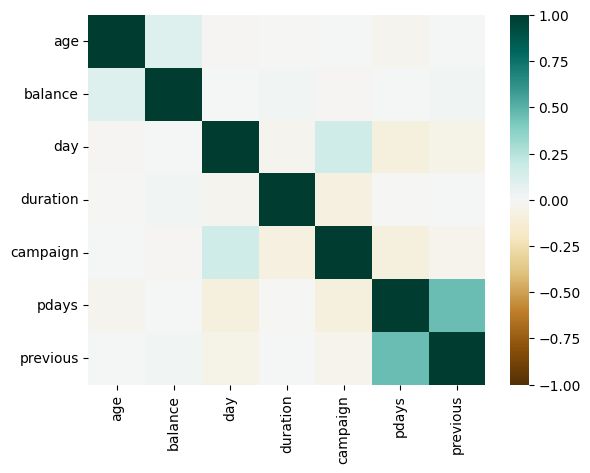

In [40]:
sns.heatmap(df[numeric_features].corr(), 
            xticklabels=numeric_features,
            yticklabels=numeric_features,
            cmap='BrBG',
            vmin=-1,
            vmax=1);

In [41]:
df[numeric_features].corr()

,age,balance,day,duration,campaign,pdays,previous
age,1.000000,0.097783,-0.009120,-0.004648,0.004760,-0.023758,0.001288
balance,0.097783,1.000000,0.004503,0.021560,-0.014578,0.003435,0.016674
day,-0.009120,0.004503,1.000000,-0.030206,0.162490,-0.093044,-0.051710
duration,-0.004648,0.021560,-0.030206,1.000000,-0.084570,-0.001565,0.001203
campaign,0.004760,-0.014578,0.162490,-0.084570,1.000000,-0.088628,-0.032855
pdays,-0.023758,0.003435,-0.093044,-0.001565,-0.088628,1.000000,0.454820
previous,0.001288,0.016674,-0.051710,0.001203,-0.032855,0.454820,1.000000


In [42]:
# for feature in ['age', 'balance']:
#     df = df[(df[feature] < df[feature].quantile(0.975)) & (df[feature] > df[feature].quantile(0.025))]
# df.shape

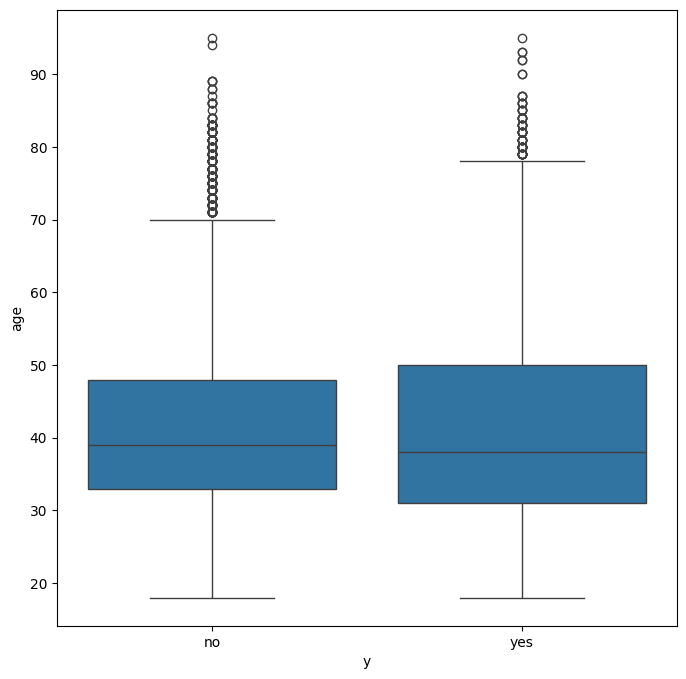

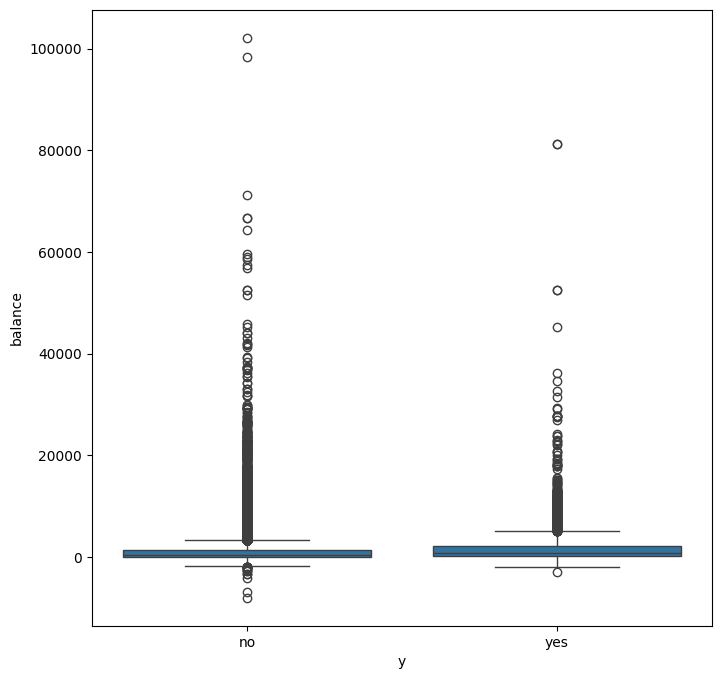

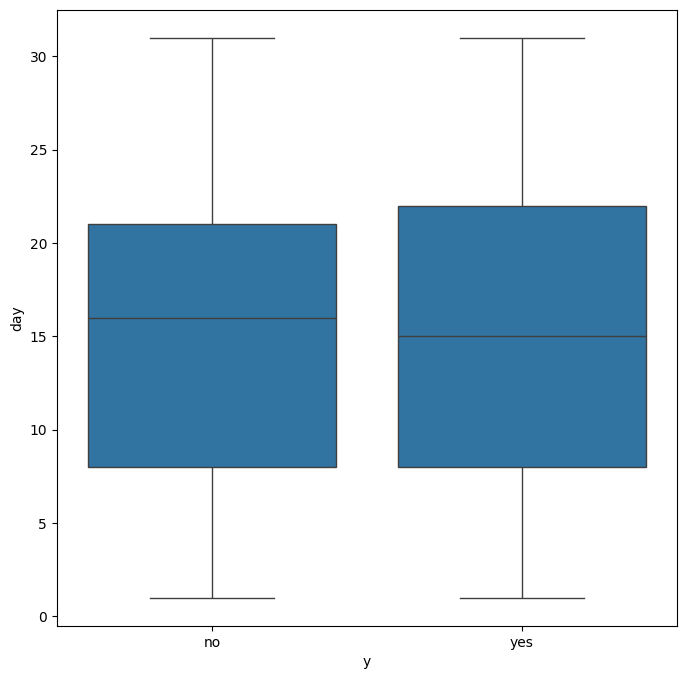

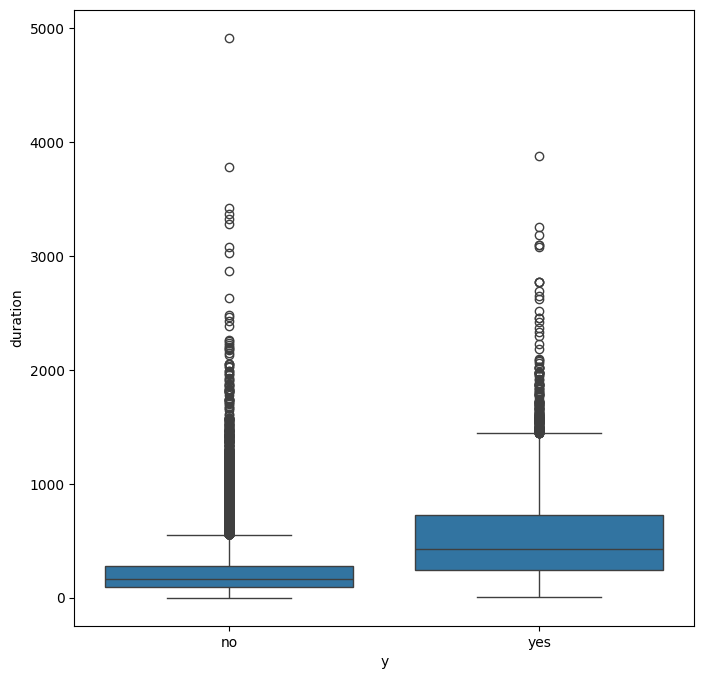

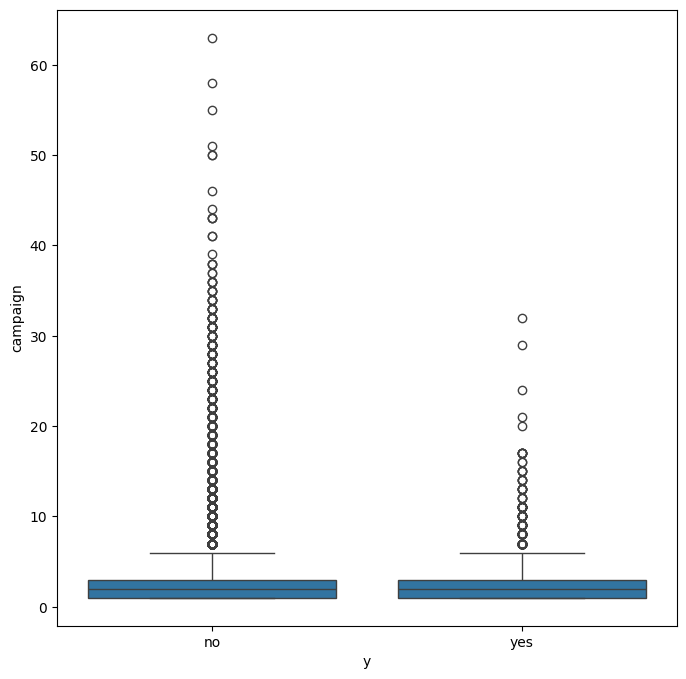

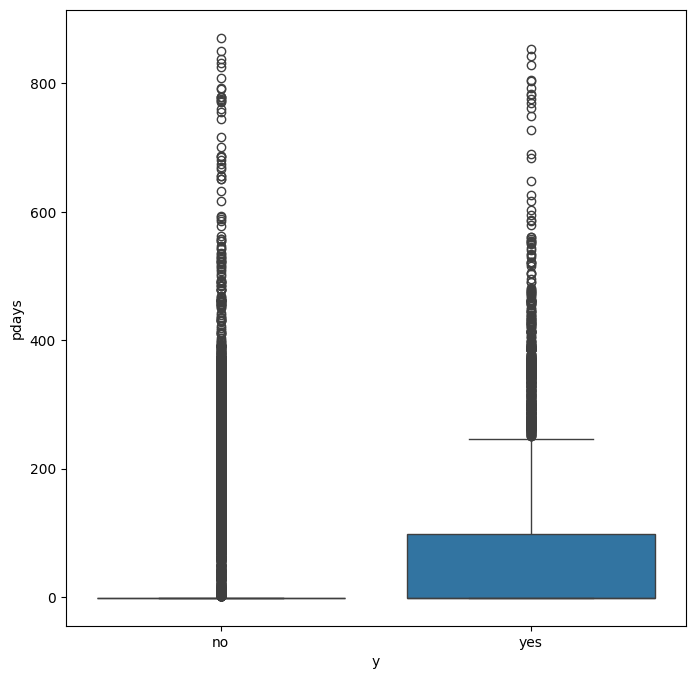

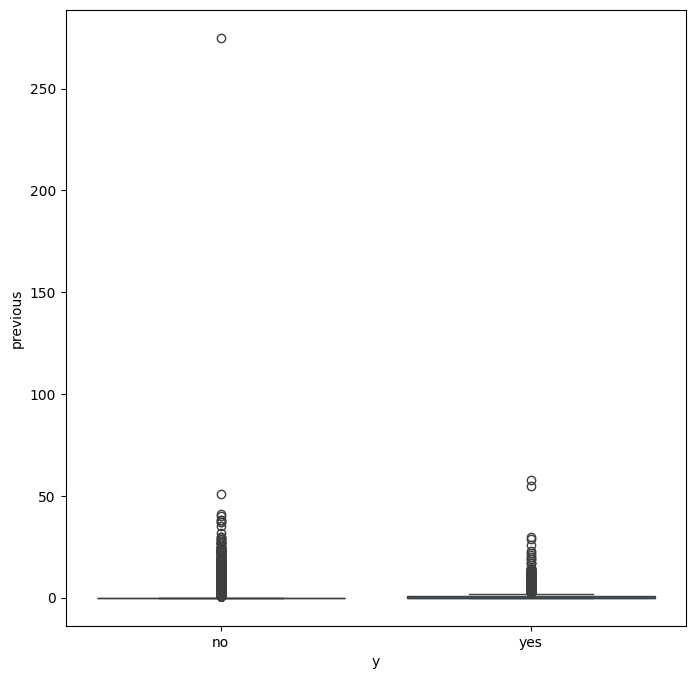

In [43]:
for feature in numeric_features:
    fig = plt.figure(figsize=(8, 8))
    sns.boxplot(data=df, x='y', y=feature) 
    plt.show()

In [44]:
df['test'] = 0
test['test'] = 1
df = pd.concat((df, test), axis=0)

In [45]:
df.y = (df.y == 'yes').astype(np.int32)

Text(0.5, 0, 'balance')

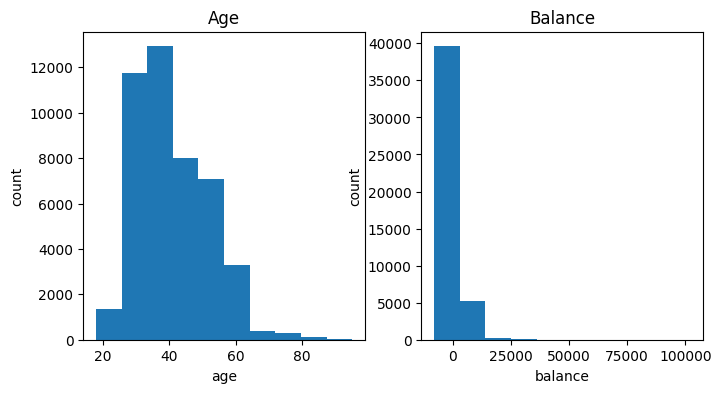

In [46]:
ig, axs = plt.subplots(figsize=(8, 4), ncols=2)
axs[0].hist(df[df.test == 0].age)
axs[0].set_title('Age')
axs[0].set_ylabel("count")
axs[0].set_xlabel("age")

axs[1].hist(df[df.test == 0].balance)
axs[1].set_title('Balance')
axs[1].set_ylabel("count")
axs[1].set_xlabel("balance")

In [47]:
@np.vectorize
def transform_balance(x):
    res = 0
    if x == 0:
        res = 0 
    elif x > 0:
        res = np.log(x)
    else:
        res = -np.log(-x)
    return res

In [48]:
# df.balance = transform_balance(df.balance)
# df.age = np.log(df.age)

Text(0.5, 0, 'balance')

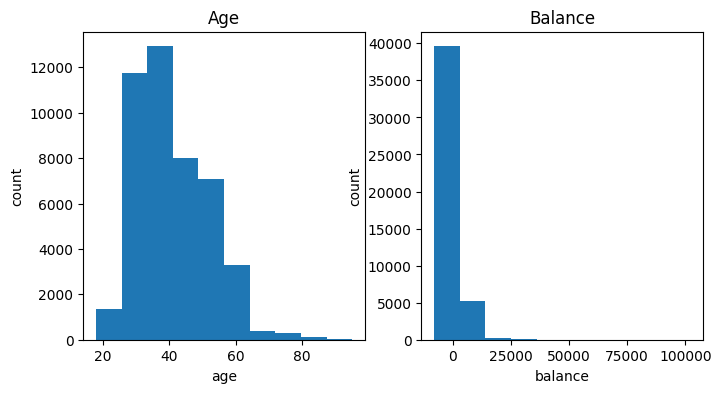

In [49]:
igd, axs = plt.subplots(figsize=(8, 4), ncols=2)
axs[0].hist(df[df.test == 0].age)
axs[0].set_title('Age')
axs[0].set_ylabel("count")
axs[0].set_xlabel("age")

axs[1].hist(df[df.test == 0].balance)
axs[1].set_title('Balance')
axs[1].set_ylabel("count")
axs[1].set_xlabel("balance")

In [50]:
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
categorical_features

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

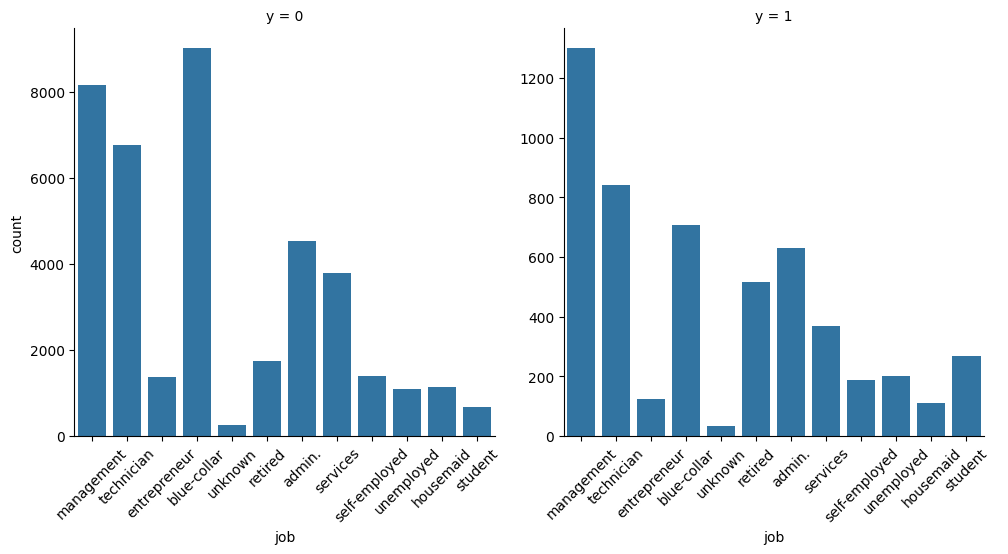

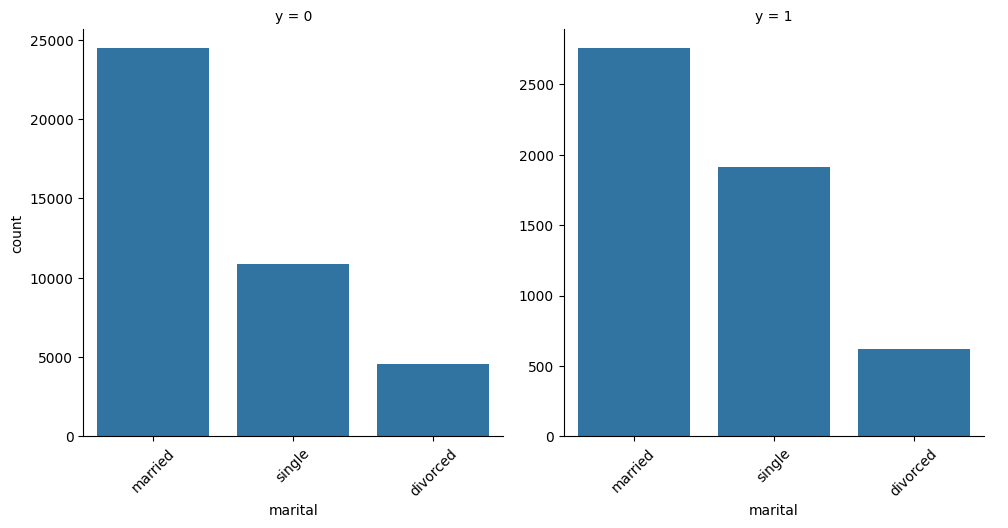

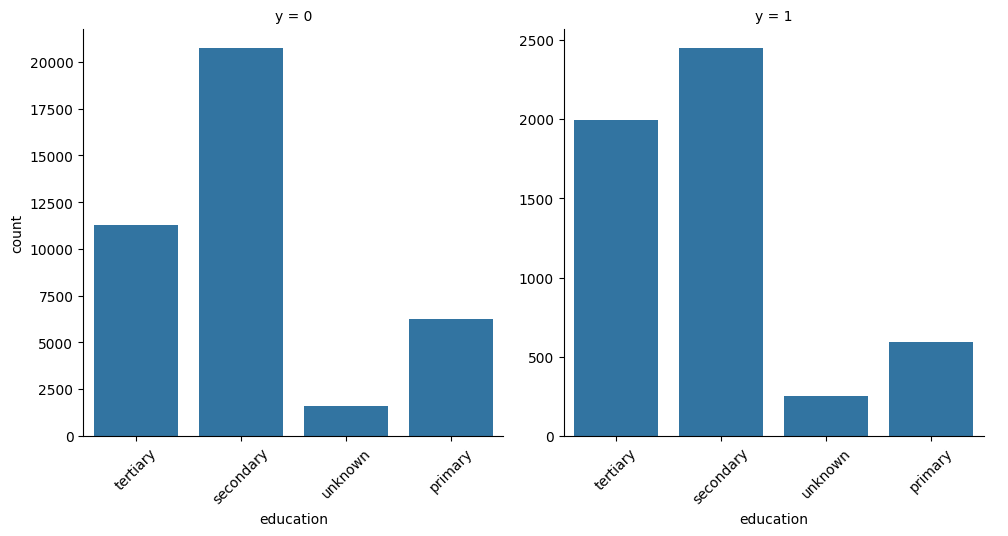

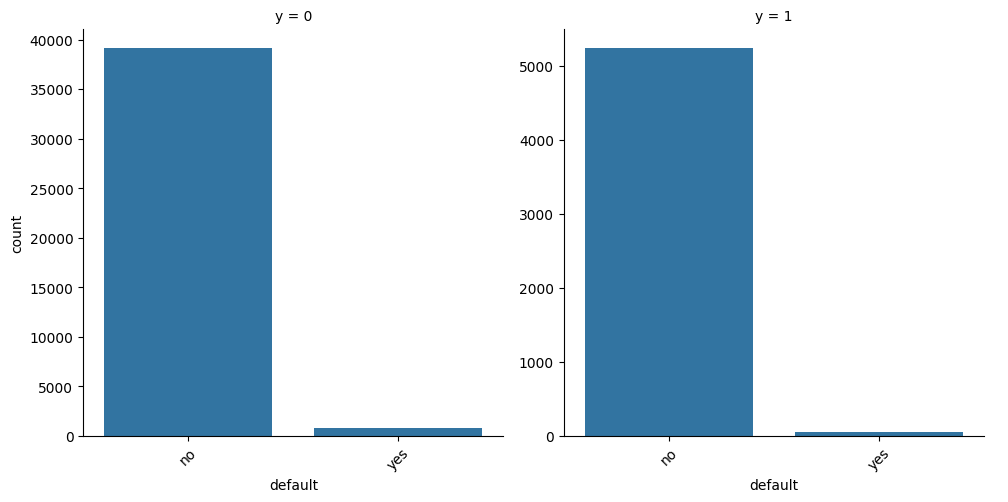

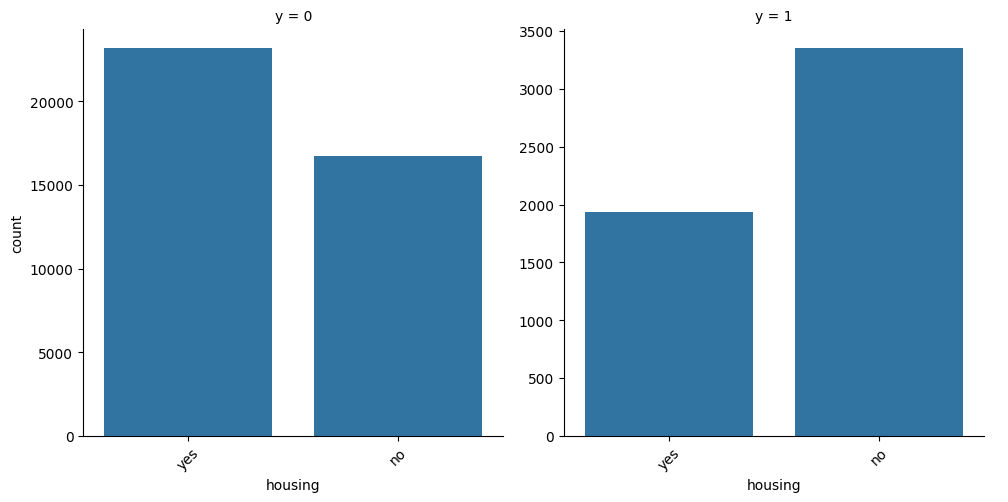

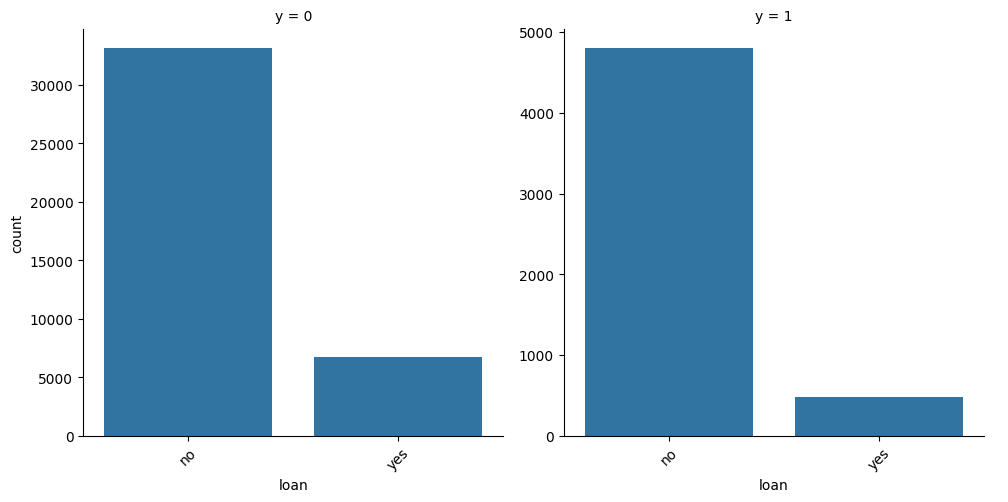

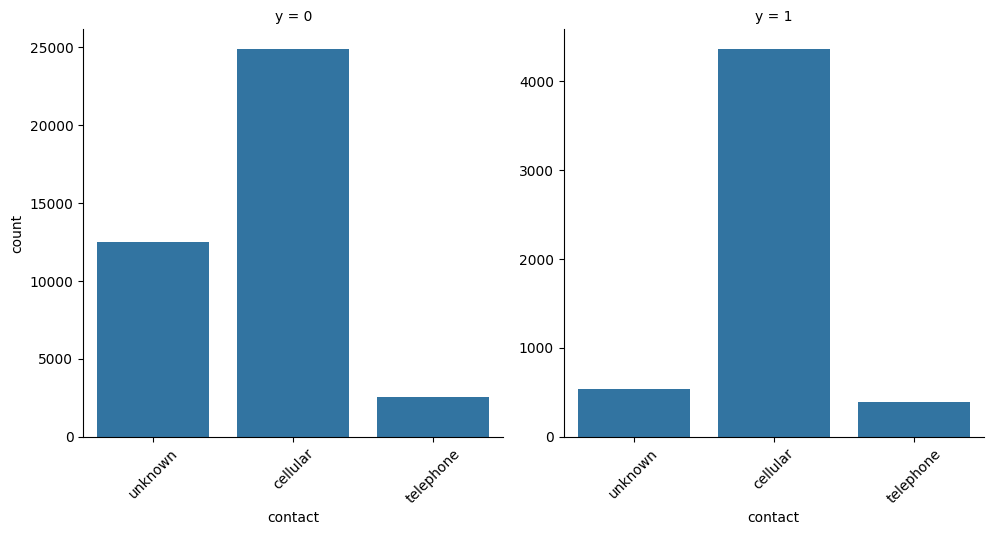

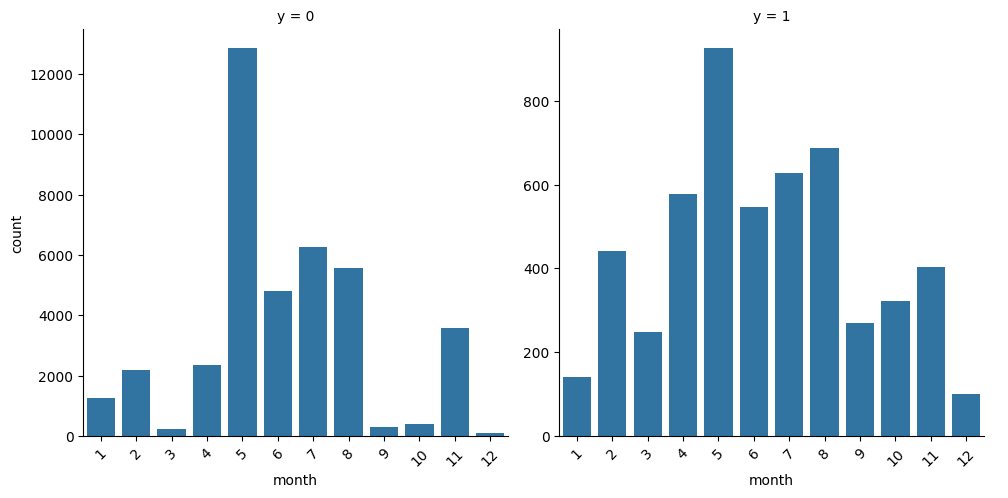

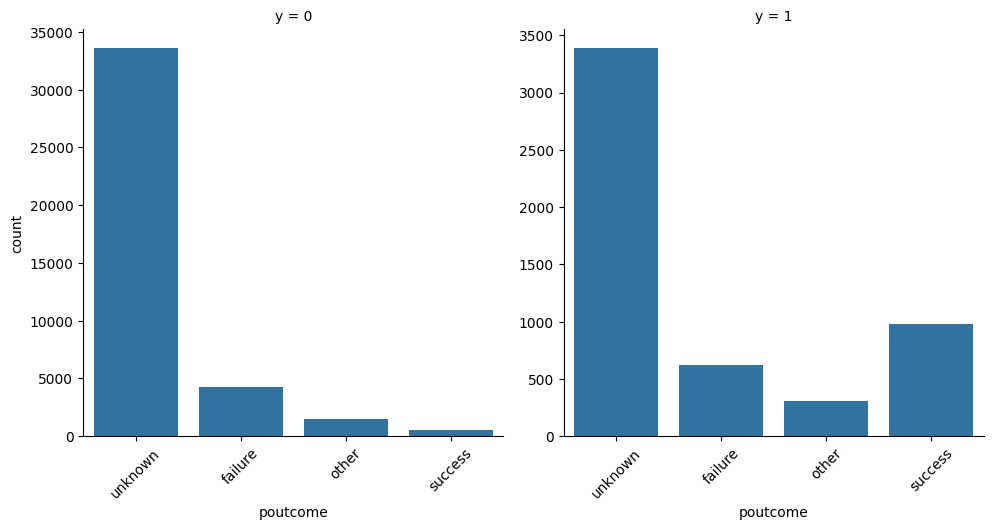

In [51]:
for feature in categorical_features:
    ax = sns.catplot(data=df[df.test == 0], x=feature, col='y', kind='count', sharey=False)
    ax.set_xticklabels(rotation=45)

In [52]:
df.drop(columns=['previous', 'pdays', 'day', 'default', 'duration', 'campaign'], inplace=True)
df.head()

,age,job,marital,education,balance,housing,loan,contact,month,poutcome,y,test
0,58,management,married,tertiary,2143,yes,no,unknown,5,unknown,0,0
1,44,technician,single,secondary,29,yes,no,unknown,5,unknown,0,0
2,33,entrepreneur,married,secondary,2,yes,yes,unknown,5,unknown,0,0
3,47,blue-collar,married,unknown,1506,yes,no,unknown,5,unknown,0,0
4,33,unknown,single,unknown,1,no,no,unknown,5,unknown,0,0


In [53]:
X_test = df[df.test == 1].drop(columns=['test', 'y'])
y_test = df[df.test == 1].y

X = df[df.test == 0].drop(columns=['test', 'y'])
y = df[df.test == 0].y


In [54]:
X

,age,job,marital,education,balance,housing,loan,contact,month,poutcome
0,58,management,married,tertiary,2143,yes,no,unknown,5,unknown
1,44,technician,single,secondary,29,yes,no,unknown,5,unknown
2,33,entrepreneur,married,secondary,2,yes,yes,unknown,5,unknown
3,47,blue-collar,married,unknown,1506,yes,no,unknown,5,unknown
4,33,unknown,single,unknown,1,no,no,unknown,5,unknown
...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,825,no,no,cellular,11,unknown
45207,71,retired,divorced,primary,1729,no,no,cellular,11,unknown
45208,72,retired,married,secondary,5715,no,no,cellular,11,success
45209,57,blue-collar,married,secondary,668,no,no,telephone,11,unknown


In [55]:
X_train, X_val, y_train, y_val  = train_test_split(X, y, train_size=0.85, shuffle=True, random_state=22)

In [56]:
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

ct = ColumnTransformer(
    [
        ('scaler', RobustScaler(), numeric_features),
        ('OHE', OneHotEncoder(), categorical_features)
    ]
)
numeric_features, categorical_features

(['age', 'balance'],
 ['job',
  'marital',
  'education',
  'housing',
  'loan',
  'contact',
  'month',
  'poutcome'])

In [57]:
cs = np.linspace(0.1, 10, 80)

logreg_pipline = Pipeline(
    steps=(
        ('transforms', ct),
        ('model', LogisticRegression(penalty='l2'))
    )
)

searcher = GridSearchCV(logreg_pipline, param_grid=[{'model__C': cs}], cv=5, n_jobs=-1)
searcher.fit(X_train, y_train)
c = searcher.best_params_['model__C']

In [58]:
logreg_pipline = Pipeline(
    steps=(
        ('transforms', ct),
        ('model', LogisticRegression(penalty='l2', C=c))
    )
)

logreg_model = logreg_pipline.fit(X_train, y_train)

In [59]:
y_train.mean(), y_val.mean()

(np.float64(0.1171771318535481), np.float64(0.1158950162194043))

In [60]:
y_pred = logreg_model.predict(X_val)
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

Accuracy: 0.89
Precision: 0.63
Recall: 0.18
Fbeta_score(beta=1.5): 0.23


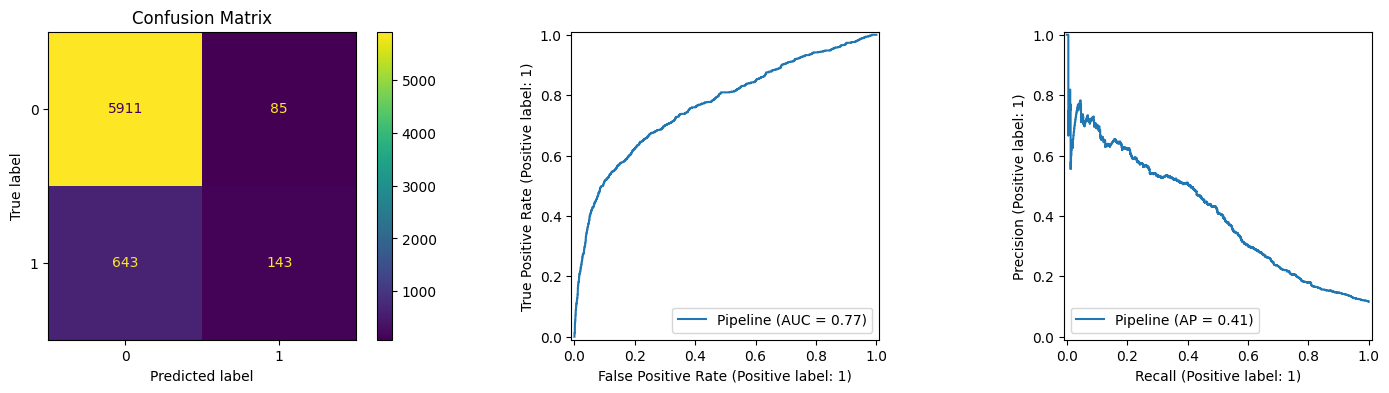

In [61]:
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=np.array([[tn, fp], [fn, tp]]))

disp.plot(ax=axs[0])
axs[0].set_title("Confusion Matrix")
RocCurveDisplay.from_estimator(logreg_model, X_val, y_val, ax=axs[1])
PrecisionRecallDisplay.from_estimator(logreg_model, X_val, y_val, ax=axs[2])

print('Accuracy:', round(accuracy_score(y_val, y_pred), 2))
print('Precision:', round(precision_score(y_val, y_pred), 2))
print('Recall:', round(recall_score(y_val, y_pred), 2))
print('Fbeta_score(beta=1.5):', round(fbeta_score(y_val, y_pred, beta=1.5), 2))

In [62]:
scorer = make_scorer(fbeta_score, beta=1.3)
classifier_tuned = TunedThresholdClassifierCV(logreg_model, scoring=scorer).fit(X_val, y_val)
threshold = classifier_tuned.best_threshold_
threshold


np.float64(0.17063983268246508)

Accuracy: 0.86
Precision: 0.42
Recall: 0.5
Fbeta_score(beta=1.5): 0.47


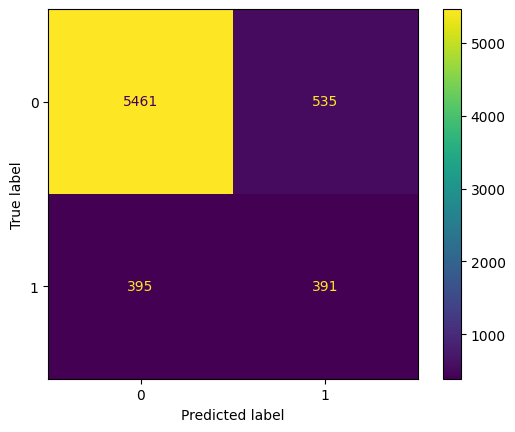

In [63]:
y_pred = (logreg_model.predict_proba(X_val)>threshold)*1

print('Accuracy:', round(accuracy_score(y_val, y_pred[:, 1]), 2))
print('Precision:', round(precision_score(y_val, y_pred[:, 1]), 2))
print('Recall:', round(recall_score(y_val, y_pred[:, 1]), 2))
print('Fbeta_score(beta=1.5):', round(fbeta_score(y_val, y_pred[:, 1], beta=1.5), 2))

tn, fp, fn, tp = confusion_matrix(y_val, y_pred[:, 1]).ravel()
ConfusionMatrixDisplay(confusion_matrix=np.array([[tn, fp], [fn, tp]])).plot()

Accuracy: 0.85
Precision: 0.38
Recall: 0.44
Fbeta_score(beta=1.5): 0.42


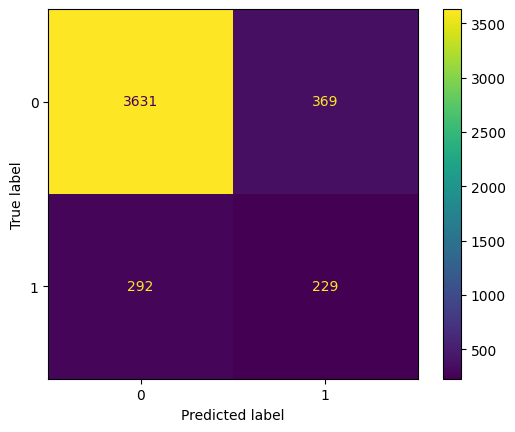

In [64]:
y_pred = (logreg_model.predict_proba(X_test)>threshold)*1

print('Accuracy:', round(accuracy_score(y_test, y_pred[:, 1]), 2))
print('Precision:', round(precision_score(y_test, y_pred[:, 1]), 2))
print('Recall:', round(recall_score(y_test, y_pred[:, 1]), 2))
print('Fbeta_score(beta=1.5):', round(fbeta_score(y_test, y_pred[:, 1], beta=1.5), 2))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred[:, 1]).ravel()
ConfusionMatrixDisplay(confusion_matrix=np.array([[tn, fp], [fn, tp]])).plot()